# TPLCNet 教程

**环境准备说明：** 本笔记本讲解 TPLCNet 的核心模块，并给出真实温室数据上的可视化示例。
- 只翻译/整理文字说明，代码逻辑保持不变
- 如需运行示例，请先按第 1 节准备依赖与数据路径

### 1. 环境与依赖

说明：
- 建议 Python 3.9+
- 建议使用你现有的 `TPLC_Net` conda 环境
- 下面的安装命令仅在缺依赖时使用

In [1]:
# 可选：安装依赖（在 Jupyter/VS Code Notebook 中推荐用 %pip）
# %pip install -r requirements.txt

import sys
from pathlib import Path

def find_project_root(start: Path) -> Path:
    """从当前目录向上查找包含 tplc_algo 的目录，作为 TPLC_Net 根目录。"""
    cur = start.resolve()
    for _ in range(10):
        if (cur / 'tplc_algo').exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError('未找到 TPLC_Net 根目录（缺少 tplc_algo）。请把工作目录切到 TPLC_Net 下再运行。')

ROOT = find_project_root(Path.cwd())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print('ROOT =', ROOT)
print('Python =', sys.executable)

ROOT = D:\degree_code\scheme_1\TPLC_Net
Python = e:\anaconda\envs\TPLC_Net\python.exe


### 2. 包导入

我们将导入：
- 模型：`TPLCNet`
- 模块层：`MultiScaleGenerator`、`DepthwiseSeparableConv2d`、`extract_topk_periods`、`reshape_1d_to_2d/reshape_2d_to_1d`
- 训练器：`Trainer`
- 数据管线：`prepare_greenhouse_datasets/make_loaders`

In [2]:
import inspect
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

# 中文显示（按项目约定）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from tplc_algo.models.tplc_model import TPLCNet, MultiScaleGenerator
from tplc_algo.models.layers import (
    DepthwiseSeparableConv2d,
    extract_topk_periods,
    reshape_1d_to_2d,
    reshape_2d_to_1d,
)
from tplc_algo.train.trainer import Trainer, TrainConfig
from tplc_algo.pipeline import prepare_greenhouse_datasets, make_loaders

print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())

torch: 2.5.1+cu121
cuda available: True


### 3. TPLCNet 总体结构（先建立直觉）

#### 3.1 输入/输出张量约定
- 输入 $x$：形状 `[B, T, C_{in}]`
- 输出 $\hat{y}$：形状 `[B, pred_len, C_{out}]`

#### 3.2 一句话概括
TPLCNet = **多尺度下采样** +（每个尺度上）**FFT 识别主周期** → 1D→2D → **2D 深度可分离卷积** → **多周期加权融合** → **多尺度预测融合**。

### 4. 模块 A：MultiScaleGenerator（多尺度生成器）
位置：`tplc_algo/models/tplc_model.py`

In [3]:
print(inspect.getsource(MultiScaleGenerator))

class MultiScaleGenerator(nn.Module):
    """多尺度序列生成：使用平均池化实现 stride=2 的下采样。"""

    def __init__(self, num_scales: int) -> None:
        super().__init__()
        self.num_scales = int(num_scales)

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        # x: [B, C, T]
        scales = [x]
        cur = x
        for _ in range(self.num_scales):
            # 平均池化下采样，保持变量一致
            cur = F.avg_pool1d(cur, kernel_size=2, stride=2, ceil_mode=False)
            scales.append(cur)
        return scales



#### 4.1 平均池化下采样示意图（真实温室数据）
下面用真实温室序列，展示 `avg_pool1d(kernel=2, stride=2)` 如何把长度从 `T` 变成 `T/2`、`T/4`…

D:\degree_code\scheme_1\TPLC_Net\tplc_algo\data\greenhouse_dataset.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


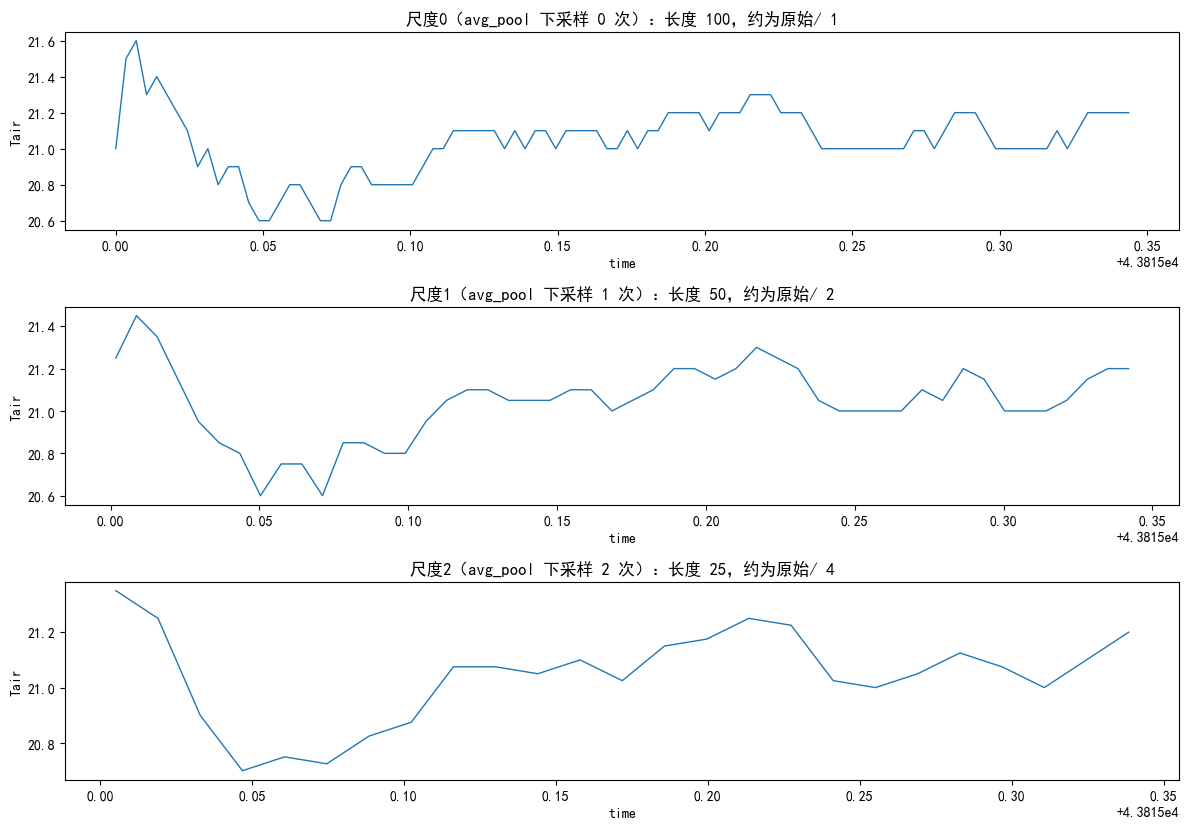

平均池化示例（kernel=2, stride=2）：
[0,1] -> (21.0000 + 21.5000) / 2 = 21.2500
[2,3] -> (21.6000 + 21.3000) / 2 = 21.4500
[4,5] -> (21.4000 + 21.3000) / 2 = 21.3500
[6,7] -> (21.2000 + 21.1000) / 2 = 21.1500


In [4]:
from pathlib import Path
from tplc_algo.data.greenhouse_dataset import load_team_merged_dataframe

# 1) 自动定位数据根目录（和第 8 节一致的逻辑）
candidates = [
    ROOT.parent / "datasets" / "自主温室挑战赛",
    ROOT.parent.parent / "datasets" / "自主温室挑战赛",
]
dataset_root_demo = None
for p in candidates:
    if p.exists():
        dataset_root_demo = p
        break

if dataset_root_demo is None:
    raise RuntimeError(
        "找不到 datasets/自主温室挑战赛。请手动指定 dataset_root_demo，例如：\n"
        r"dataset_root_demo = Path(r'..\datasets\自主温室挑战赛')"
    )

# 2) 读取并对齐多表，选一个变量做演示
team_demo = "AICU"
merged_df = load_team_merged_dataframe(Path(dataset_root_demo) / team_demo)

preferred = ["Tair", "Rhair", "CO2air"]
value_col = next((c for c in preferred if c in merged_df.columns), None)
if value_col is None:
    value_col = [c for c in merged_df.columns if c != "time"][0]

t = merged_df["time"].to_numpy(np.float64)
x = merged_df[value_col].to_numpy(np.float32)

# 3) 截取一段真实序列（不要太长，图更清晰）
N = int(min(100, len(x)))
t0 = t[:N]
x0 = x[:N]

# 4) 用 MultiScaleGenerator 做平均池化下采样（它内部就是 avg_pool1d）
x_t = torch.from_numpy(x0).view(1, 1, -1)  # [B=1, C=1, T]
ms = MultiScaleGenerator(num_scales=2)      # 原始 + 2 次下采样 => 3 个尺度
scales = ms(x_t)                             # list: [1,1,Tm]

# 5) 为每个尺度构造“对应的 time”（与 avg_pool2 的窗口匹配：相邻两点取均值）
times = [t0]
for _ in range(1, len(scales)):
    prev = times[-1]
    L = (len(prev) // 2) * 2      # 保证成对
    prev = prev[:L]
    times.append(0.5 * (prev[0::2] + prev[1::2]))

# 6) 画图：每个尺度一行（最直观）
fig, axes = plt.subplots(len(scales), 1, figsize=(12, 2.8 * len(scales)), sharex=False)
if len(scales) == 1:
    axes = [axes]

for i, (s, ti) in enumerate(zip(scales, times)):
    yi = s[0, 0].detach().cpu().numpy()
    axes[i].plot(ti, yi, linewidth=1.0)
    axes[i].set_title(f"尺度{i}（avg_pool 下采样 {i} 次）：长度 {len(yi)}，约为原始/ {2**i}")
    axes[i].set_xlabel("time")
    axes[i].set_ylabel(value_col)

plt.tight_layout()
plt.show()

# 7) 再打印一个“平均池化到底怎么计算”的小例子（前 8 个点）
print("平均池化示例（kernel=2, stride=2）：")
for j in range(0, min(8, len(x0) - 1), 2):
    avg = 0.5 * (x0[j] + x0[j + 1])
    print(f"[{j},{j+1}] -> ({x0[j]:.4f} + {x0[j+1]:.4f}) / 2 = {avg:.4f}")

### 5. 模块 B：extract_topk_periods（FFT 周期识别）
位置：`tplc_algo/models/layers.py`

In [5]:
print(inspect.getsource(extract_topk_periods))

def extract_topk_periods(
    x: torch.Tensor,
    top_k: int,
    eps: float = 1e-6,
) -> PeriodInfo:
    """基于 FFT 从序列中提取 top_k 个显著周期。

    参考 scheme_1_algo.md：对归一化后的多变量序列求和得到 1D 序列，再 FFT，选振幅最大的前 K 个频率。

    参数
    - x: [B, C, L] 或 [B, L]，数值序列
    返回
    - periods: [K]，周期长度（整数）
    - amplitudes: [K]，对应振幅（用于 softmax 权重）
    """

    if x.dim() == 3:
        # 对每个变量在时间维做 LayerNorm，再沿变量维求和
        b, c, l = x.shape
        x_ln = F.layer_norm(x, normalized_shape=(l,))
        seq = x_ln.sum(dim=1)  # [B, L]
    elif x.dim() == 2:
        seq = x
        l = x.shape[-1]
    else:
        raise ValueError("x 维度必须是 [B,C,L] 或 [B,L]")

    # rFFT: [B, L//2 + 1]
    fft = torch.fft.rfft(seq, dim=-1)
    mag = torch.abs(fft)  # [B, F]
    mag = mag.mean(dim=0)  # [F]
    if mag.numel() > 0:
        mag[0] = 0.0  # 去掉直流分量

    # 若长度过短，直接返回周期=1
    if mag.numel() <= 1:
        periods = torch.ones(top_k, dtype=torch.long, device=x.device)
        amps = torch.ones(top_k, dtype=torch.float32, dev

### 6. 模块 C：reshape_1d_to_2d / reshape_2d_to_1d（1D↔2D 重塑）
位置：`tplc_algo/models/layers.py`

In [1]:
print(inspect.getsource(reshape_1d_to_2d))
print(inspect.getsource(reshape_2d_to_1d))

NameError: name 'inspect' is not defined

### 7. 模块 D：DepthwiseSeparableConv2d（2D 深度可分离卷积）
位置：`tplc_algo/models/layers.py`

In [ ]:
print(inspect.getsource(DepthwiseSeparableConv2d))

### 8. 模块 E：TPLCNet（总模型）
位置：`tplc_algo/models/tplc_model.py`

In [ ]:
print(inspect.getsource(TPLCNet))

### 9. 真实温室数据：加载与可视化

In [ ]:
# 尝试用相对路径自动定位（找不到就手动改）
candidates = [
    ROOT.parent / 'datasets' / '自主温室挑战赛',
    ROOT.parent.parent / 'datasets' / '自主温室挑战赛',
]
dataset_root = None
for p in candidates:
    if p.exists():
        dataset_root = p
        break

print('auto dataset_root:', dataset_root)
# 如果这里是 None，请手动指定，例如：
# dataset_root = Path(r'..\datasets\自主温室挑战赛')

In [ ]:
from pathlib import Path

team = 'AICU'
seq_len_real = 96
pred_len_real = 24
batch_size_real = 32

if dataset_root is None:
    raise RuntimeError('dataset_root 为 None。请先在上一节手动设置真实温室数据路径。')

prepared = prepare_greenhouse_datasets(
    dataset_root=Path(dataset_root),
    team=team,
    seq_len=seq_len_real,
    pred_len=pred_len_real,
    stride=1,
)
_, _, _ = make_loaders(prepared, batch_size=batch_size_real)

x0, y0 = prepared.test_ds[0]
x0 = x0.unsqueeze(0)
y0 = y0.unsqueeze(0)

model_vis = TPLCNet(
    input_dim=len(prepared.feature_cols),
    target_dim=len(prepared.target_cols),
    seq_len=seq_len_real,
    pred_len=pred_len_real,
    num_scales=2,
    top_k_periods=3,
    hidden_dim=64,
)
model_vis.eval()

print('x0:', tuple(x0.shape), 'y0:', tuple(y0.shape))
print('targets:', prepared.target_cols)

#### 9.1 原始序列展示（反标准化，更直观看周期性）
先把真实温室序列画出来，并用 FFT 找到的 top-1 周期 p 做辅助标注。

In [ ]:
# ===== 8.0 原始序列展示（反标准化） =====

# 1) 选一个变量（优先第一个目标变量）
if len(prepared.target_cols) > 0 and prepared.target_cols[0] in prepared.feature_cols:
    ch_name = prepared.target_cols[0]
    ch_idx = prepared.feature_cols.index(ch_name)
else:
    ch_name = prepared.feature_cols[0]
    ch_idx = 0

# 2) 从完整的 test 数据里取一段更长的序列（test_ds.merged_df 含 time + 标准化后的特征）
df_s = prepared.test_ds.merged_df.sort_values("time").reset_index(drop=True)
t_all = df_s["time"].to_numpy(np.float64)

x_all_s = df_s[prepared.feature_cols].to_numpy(np.float32)           # 标准化
x_all_raw = prepared.all_scaler.inverse_transform(x_all_s)           # 反标准化
y_all_raw = x_all_raw[:, ch_idx]

# 温室 5min 采样：一天≈288个点。这里展示3天（可改大）
show_len = int(min(len(y_all_raw), 288 * 3))
y_seg = y_all_raw[:show_len]
t_seg = t_all[:show_len]

# 3) 在这段“原始序列”上跑一次 FFT 找 top-1 周期（用单通道即可）
with torch.no_grad():
    x_ct = torch.from_numpy(y_seg).float().view(1, 1, -1)  # [B=1,C=1,L]
    info = extract_topk_periods(x_ct, top_k=5)
    p_top = int(info.periods[0].item())
    periods = info.periods.cpu().numpy().tolist()

# 4) 画图：原始序列 + 周期竖线 + 平移叠加
idx = np.arange(show_len)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].plot(idx, y_seg, linewidth=1.2)
axes[0].set_title(f"原始序列（反标准化）：{ch_name}，top-1 周期 p={p_top}（索引尺度）")
axes[0].set_xlabel("窗口内时间步 t（索引）")
axes[0].set_ylabel(ch_name)

# 用竖线标出周期位置（更直观）
if p_top > 0:
    for k in range(0, show_len, p_top):
        axes[0].axvline(k, color="gray", alpha=0.25, linestyle="--", linewidth=1)

# 平移叠加：y[t] vs y[t+p]
if 0 < p_top < show_len:
    base = y_seg[: show_len - p_top]
    shifted = y_seg[p_top:]
    axes[1].plot(np.arange(len(base)), base, label="y[t]", linewidth=1.2)
    axes[1].plot(np.arange(len(base)), shifted, label=f"y[t+p] (p={p_top})", linewidth=1.2, alpha=0.8)
    axes[1].set_title("叠加对比：y[t] 与 y[t+p]（越重合越说明有周期性）")
    axes[1].set_xlabel("对齐后的索引 t")
    axes[1].legend()
else:
    axes[1].axis("off")
    axes[1].text(0.1, 0.5, f"p_top={p_top} 不适合叠加（p<=0 或 p>=len）", transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

print("top periods:", periods)

#### 9.2 FFT 频谱图 + top-K 周期标注

In [ ]:
def compute_fft_mag_from_x(x_ct: torch.Tensor) -> torch.Tensor:
    """复现 extract_topk_periods 的核心处理，用于画完整频谱。

    x_ct: [C, L]
    return: mag [L_rfft]
    """
    if x_ct.dim() != 2:
        raise ValueError('x_ct 必须是 [C, L]')
    _, l = x_ct.shape
    x_ln = F.layer_norm(x_ct, normalized_shape=(l,))
    seq = x_ln.sum(dim=0, keepdim=True)
    fft = torch.fft.rfft(seq, dim=-1)
    mag = torch.abs(fft).squeeze(0)
    if mag.numel() > 0:
        mag[0] = 0.0
    return mag

# 8.0 已经构造了 y_seg（反标准化长序列）。这里直接复用它来对齐日周期。
if 'y_seg' not in globals():
    raise RuntimeError('未找到 y_seg。请先运行 8.0 原始序列展示的 cell。')

with torch.no_grad():
    x_ct_raw = torch.from_numpy(y_seg).float().view(1, -1)  # [C=1, L]
    info_raw = extract_topk_periods(x_ct_raw.unsqueeze(0), top_k=5)
    mag_raw = compute_fft_mag_from_x(x_ct_raw)

L_raw = int(x_ct_raw.shape[-1])
periods_raw = [int(p) for p in info_raw.periods.cpu().numpy().tolist()]

freq = torch.arange(mag_raw.numel())
plt.figure(figsize=(10, 4))
plt.plot(freq[1:].cpu().numpy(), mag_raw[1:].cpu().numpy(), linewidth=1.2)
plt.title(f'FFT 频谱（长序列，对齐 8.0；L={L_raw}）')
plt.xlabel('频率索引 f')
plt.ylabel('幅值 |FFT|')

# rFFT: 频率 bin k 对应周期约为 L/k，因此 period p -> k ≈ L/p
for p in periods_raw:
    k = int(round(L_raw / max(1, p)))
    k = max(1, k)
    if k < mag_raw.numel():
        plt.scatter([k], [mag_raw[k].item()], s=30)
        plt.text(k, mag_raw[k].item(), f' p={p}', fontsize=9)

plt.tight_layout()
plt.show()

print('top periods (raw long series):', periods_raw)

#### 9.3 1D→2D 热力图（单通道 + 通道均值）

In [ ]:
def plot_rows_as_small_traces(
    mat: np.ndarray,
    title: str,
    max_rows: int = 3,                 # 你要“三个部分”，这里固定 3
    normalize_each_row: bool = True,
):
    if mat.ndim != 2:
        raise ValueError("mat 必须是二维 [H, W]")
    H, W = mat.shape
    n = int(min(max_rows, H))
    row_ids = np.linspace(0, H - 1, n).round().astype(int)

    fig, axes = plt.subplots(n, 1, figsize=(6, 1.25 * n), sharex=True)
    if n == 1:
        axes = [axes]

    xs = np.arange(W)
    for ax, rid in zip(axes, row_ids):
        y = mat[rid].astype(np.float32)
        if normalize_each_row:
            y = (y - y.mean()) / (y.std() + 1e-6)

        ax.plot(xs, y, color="black", linewidth=1.0)
        ax.set_yticks([])
        ax.set_xticks([])

        # 每个子图自己的黑色边框
        for sp in ax.spines.values():
            sp.set_visible(True)
            sp.set_color("black")
            sp.set_linewidth(1.2)

    axes[0].set_title(title)
    plt.tight_layout()
    plt.show()


# ===== 8.2 1D→2D 热力图（单通道 + 通道均值） =====
# 依赖 8.0 单元格生成的 y_seg / ch_name / p_top
if 'y_seg' not in globals():
    raise RuntimeError('未找到 y_seg。请先运行 8.0 原始序列展示的 cell。')

# 优先复用 8.0 的 top-1 周期；否则再跑一次 FFT 估计
period_use = int(globals().get('p_top', 0))
if period_use <= 0:
    with torch.no_grad():
        x_ct = torch.from_numpy(y_seg).float().view(1, 1, -1)
        info = extract_topk_periods(x_ct, top_k=5)
        period_use = int(info.periods[0].item())

# 单通道 1D→2D
with torch.no_grad():
    x_ct = torch.from_numpy(y_seg).float().view(1, 1, -1)  # [B=1,C=1,L]
    z2d, orig_len = reshape_1d_to_2d(x_ct, period=period_use)  # [B,C,H,W]

single_map = z2d[0, 0].detach().cpu().numpy()  # [H,W]
mean_map = z2d[0].mean(dim=0).detach().cpu().numpy()  # [H,W]

# 1) 热力图（更直观地看“周期内/周期间”变化）
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].imshow(single_map, aspect='auto')
axes[0].set_title(f'1D→2D 热力图（单通道：{globals().get("ch_name", "channel")}，p={period_use}）')
axes[0].set_xlabel('周期内索引（列）')
axes[0].set_ylabel('周期段索引（行）')

axes[1].imshow(mean_map, aspect='auto')
axes[1].set_title(f'1D→2D 热力图（通道均值，p={period_use}）')
axes[1].set_xlabel('周期内索引（列）')

plt.tight_layout()
plt.show()

# 2) 再用“三行波形”方式展示（你要的“三个部分”）
plot_rows_as_small_traces(single_map,  f"按日周期切片的波形（单通道：{globals().get('ch_name','channel')}，p={period_use}）", max_rows=3)
plot_rows_as_small_traces(mean_map, f"按日周期切片的波形（通道均值，p={period_use}）", max_rows=3)


#### 9.4 多尺度输出曲线对比（各尺度 vs 融合 vs 真实）

In [ ]:
def forward_tplcnet_debug(model: TPLCNet, x: torch.Tensor):
    if x.dim() != 3:
        raise ValueError('x 必须是 [B,T,C]')
    x_ct = x.transpose(1, 2).contiguous()
    scales = model.multi_scale(x_ct)

    y_ms = []
    y_sum = None
    for m, x_m in enumerate(scales):
        info = extract_topk_periods(x_m, top_k=model.top_k_periods)
        weights = torch.softmax(info.amplitudes, dim=0)

        feats = []
        for k in range(model.top_k_periods):
            p = int(info.periods[k].item())
            z2d, orig_len = reshape_1d_to_2d(x_m, period=p)
            y2d = model.conv2d(z2d)
            y1d = reshape_2d_to_1d(y2d, orig_len=orig_len)
            feats.append(y1d)

        fused = 0.0
        for k in range(model.top_k_periods):
            fused = fused + weights[k] * feats[k]

        l_m = fused.shape[-1]
        expected_lm = model.time_projs[m].in_features
        if l_m > expected_lm:
            fused_use = fused[..., -expected_lm:]
        elif l_m < expected_lm:
            fused_use = F.pad(fused, (expected_lm - l_m, 0), value=0.0)
        else:
            fused_use = fused

        pred_hidden = model.time_projs[m](fused_use)
        pred_hidden = pred_hidden.transpose(1, 2).contiguous()
        y_m = model.channel_proj(pred_hidden)

        y_ms.append(y_m)
        y_sum = y_m if y_sum is None else (y_sum + y_m)
    return y_ms, y_sum

with torch.no_grad():
    y_ms, y_sum = forward_tplcnet_debug(model_vis, x0)
    y_true_np = prepared.target_scaler.inverse_transform(y0[0].cpu().numpy())
    y_sum_np = prepared.target_scaler.inverse_transform(y_sum[0].cpu().numpy())
    y_ms_np = [prepared.target_scaler.inverse_transform(y_m[0].cpu().numpy()) for y_m in y_ms]

target_name = prepared.target_cols[0] if len(prepared.target_cols) > 0 else 'target0'
xs = np.arange(pred_len_real)
plt.figure(figsize=(10, 4))
for m, arr in enumerate(y_ms_np):
    plt.plot(xs, arr[:, 0], linewidth=1.0, label=f'尺度{m}输出')
plt.plot(xs, y_sum_np[:, 0], linewidth=2.0, label='融合输出')
plt.plot(xs, y_true_np[:, 0], linewidth=2.0, linestyle='--', label='真实值')
plt.title(f'多尺度输出对比（目标：{target_name}）')
plt.legend()
plt.tight_layout()
plt.show()